# 1. Basic workflow


This vignette shows the basic workflow of Via and how to access the different visualizations after running the computations. The dataset is a toy multifurcation.
We start by importing modules. 
the examples import is only required if running the function main_Toy() which wraps the workflow demonstrated below

In [21]:
from pyVIA.core import *
import pyVIA.datasets_via as datasets_via
#from core_working import *
import pandas as pd 
import umap 
import scanpy as sc


In [3]:
#Wrapper function that includes the various step-by-step blocks shown below 
#The wrapper shows the various types of outputs to be expected and can check your installation 
#Use the more detailed subsequent blocks of code to see how to run VIA 
# import pyVIA.examples as examples
#examples.main_Toy(ncomps=30, knn=20, random_seed=41, dataset='Toy3', foldername="/home/shobi/Trajectory/Datasets/Toy3/")

First load all the data and make an anndata object. Umap is also used to create a 2D embedding used for visualization. Umap can be substituted with tsne/phate/PCA etc.


In [7]:
'''
foldername="/home/shobi/Trajectory/Datasets/Toy3/" #folder where your datafiles are saved
df_counts = pd.read_csv(foldername + "toy_multifurcating_M8_n1000d1000.csv", delimiter=",")
df_ids = pd.read_csv(foldername + "toy_multifurcating_M8_n1000d1000_ids_with_truetime.csv", delimiter=",")

#get the cell IDs and sort them to match the order or cell IDs in the df_counts file
df_ids['cell_id_num'] = [int(s[1::]) for s in df_ids['cell_id']]
df_counts = df_counts.drop('Unnamed: 0', 1)
df_ids = df_ids.sort_values(by=['cell_id_num'])
df_ids = df_ids.reset_index(drop=True)
true_label = df_ids['group_id'].tolist()

#make anndata object with counts and group_ids 
adata_counts = sc.AnnData(df_counts, obs=df_ids)
'''
adata_counts = datasets_via.toy_multifurcating(foldername='./')
print(adata_counts)
true_label = adata_counts.obs['group_id'].tolist()
ncomps = 30
sc.tl.pca(adata_counts, svd_solver='arpack', n_comps=ncomps)

embedding = umap.UMAP().fit_transform(adata_counts.obsm['X_pca'][:, 0:10])

AnnData object with n_obs × n_vars = 1000 × 1000
    obs: 'group_id', 'true_time'
inside umap_ fuzzy simplicial n_neig 15
knn indices size 15000
coo matrix after membership strength 14000
applying symmetry in umap_
size of symmetry only 19066
result.data.size 19066
graph.data.size 19066 0.333 1.0
graph.data.size 19058 19058


### Expected Outputs
1. Cluster graph level trajectory highlighting cell type composition, pseudotime and start/end states 
2. Trajectory drawn onto UMAP embedding.
3. Lineage pathways depicting lineage probabilities towards each of the detected terminal states
4. Gene trends for each lineage for marker genes
5. Vector fields for fine-grained trajectory
6. Cluster graph trajectory colored by gene expression level

In this vignette we run VIA in two iterations. The first is a coarse-grained iteration with larger clusters and this is useful for limiting the number of proposed terminal states. The second iteration offers a more granular view and uses the terminal states detected in the coarse grained run. 

However, it is perfectly fine to run VIA on just a single iteration set at any level of coarseness/granularity (controlled by too_big_factor) and one can still retrieve good quality lineage probabilities, pseudotimes, gene trends and lineage graphs. It really depends on your data (size, characteristics etc) whether you prefer the single iteration or a double iteration setup. 
We first show the initial iteration of Via (V0) and how to extract all the visulaizations and TI from V0 without doing a second iteration. In the second half of the vignette, you can see how to link a second iteration of Via (V1) that is more granular in terms of cluster size, back to the first iteration (V0) and then continue to visualize the TI in various forms. 

2022-08-26 13:28:03.955280	Running VIA over input data of 1000 (samples) x 30 (features)
2022-08-26 13:28:03.955437	Knngraph has 20 neighbors
2022-08-26 13:28:04.428911	Finished global pruning of 20-knn graph used for clustering. Kept 46.7 % of edges. 
2022-08-26 13:28:04.434691	Number of connected components used for clustergraph  is 1
2022-08-26 13:28:04.460144	The number of components in the original full graph is 1
2022-08-26 13:28:04.460224	For downstream visualization purposes we are also constructing a low knn-graph 
2022-08-26 13:28:04.845671	Commencing community detection
2022-08-26 13:28:04.890574	Finished running Leiden algorithm. Found 43 clusters.
2022-08-26 13:28:04.891300	Merging 30 very small clusters (<10)
2022-08-26 13:28:04.892593	Finished detecting communities. Found 13 communities
2022-08-26 13:28:04.892862	Making cluster graph. Global cluster graph pruning level: 1
2022-08-26 13:28:04.897550	Graph has 1 connected components before pruning
2022-08-26 13:28:04.89967

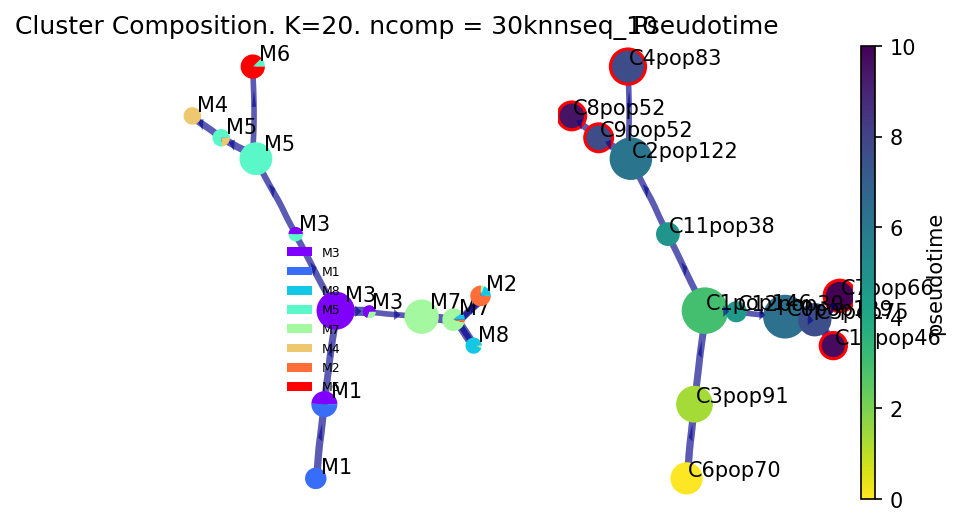

2022-08-26 13:28:09.437035	Time elapsed 5.4 seconds


In [8]:
'''
# knn: number of nearest neighbors for the KNN-graph 
# clustergraph_pruning: typically 0-3, the number of standard deviations for clustergraph pruning. level of pruning applied to the clustergraph carried forward for pseudotime and lineage probability calculations. Larger means less pruning  
# true_label: list of annotations. if these are unavailable then leave as default None
# dist_std_local: local pruning on the singlecell graph used for clustering step, 1 is quite quite minimal level of pruning.  
# too_big_factor: default 0.3. Clusters that are bigger than 30% of the entire cell population will be re-clustered. If you only plan to do one iteration of VIA before visualizing TI, consider lowering this to 0.1-0.2.  
# preserve_disconnected: if you suspect disconnected trajectories, set this to False
# dataset = 'group': works for any dataset where the root is provided as a group ID in the true_label. e.g. if root = ['Day0'], then the root will be selected as a cluster which has root like properties and is largely made up of 'Day0' cells. 
            #If you wish to run a second finegrained iteration of VIA on a disconnected dataset, but uses the terminal clusters from the previous coarse run, then the dataset should be set as 'toy' and the true_labels formatted as "T1_M1" where Tx is the x'th component and My is the y'th cluster.
            # otherwise for disconnected datasets, you can just run a single iteration of VIA where you vary too_big_factor and other parameters to change granularity and set the dataset as '' or 'group' depending on the root_user type as [groupX, groupZ ...] or [cell indices...]  
            # dataset, can be left as default value '', but then the root must be a cell index corresponding to a best guess. 
# root_user =['M1']
# visual_cluster_graph_pruning: this impacts the level of pruning done to the clustergraph before visualization. Does not impact underlying computations  
# Max_visual_outgoing_edges: controls number of edges extending from each node
'''
#define parameters
ncomps, knn, random_seed, dataset, root_user  =30,20, 41,'toy', ['M1']

v0 = VIA(adata_counts.obsm['X_pca'][:, 0:ncomps], true_label, jac_std_global=0.15, dist_std_local=1,
             knn=knn, cluster_graph_pruning_std=1, too_big_factor=0.3, root_user=root_user, preserve_disconnected=True, dataset='group',
             random_seed=random_seed)#, piegraph_arrow_head_width=0.2,             piegraph_edgeweight_scalingfactor=1.0)  
v0.run_VIA()


### VIA graph

To visualize the results of the Trajectory inference in various ways. Via offers various plotting functions.We first show the cluster-graph level trajectory abstraction consisting of two subplots colored by annotated (true_label) composition and by pseudotime

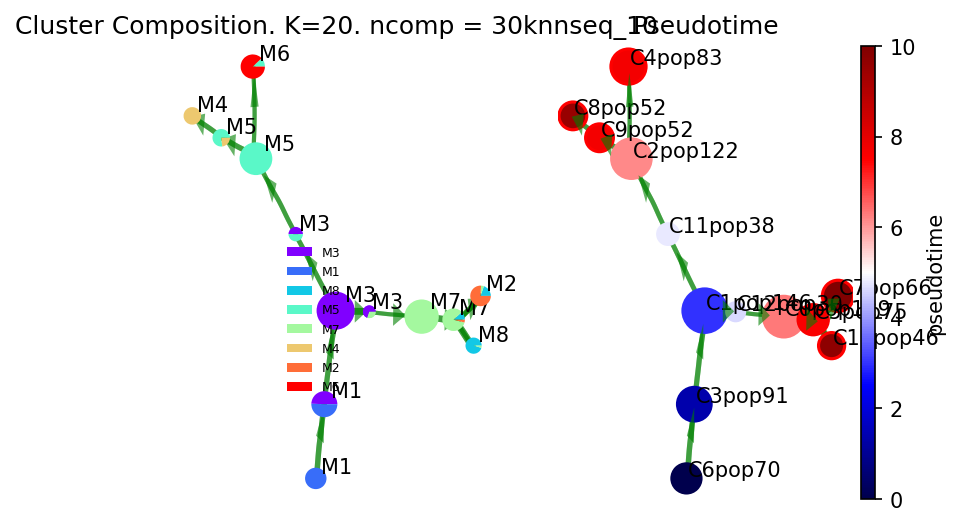

In [10]:
# draw the piechart clustergraph beside a clustergraph colored by the pseudotime ('pt') or gene expression ('gene').
# type_pt: 'pt' automatically takes the cluster level pseudotimes. 'gene' requires user to also pass gene_exp 
# gene_exp =''. In order to plot gene intensity, a list of cluster level gene/feature values should be provided as a list
# cmap = None. Can be specified and influences the cmap of the pt/gene graph
# ax_text = True. Can set to false if you don't want the cluster and populations labels 
# other features like edge width, color, alpha can be set here too
 
draw_piechart_graph(via0=v0, type_data='pt', title='Toy multifurcation', cmap='seismic', ax_text=True, gene_exp='', alpha_edge=0.5, linewidth_edge=1.5, edge_color='green', headwidth_arrow=0.2)




### Vector field
The vector field of trajectories is projected onto the embedding 

/home/shobi/anaconda3/envs/ViaEnv/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


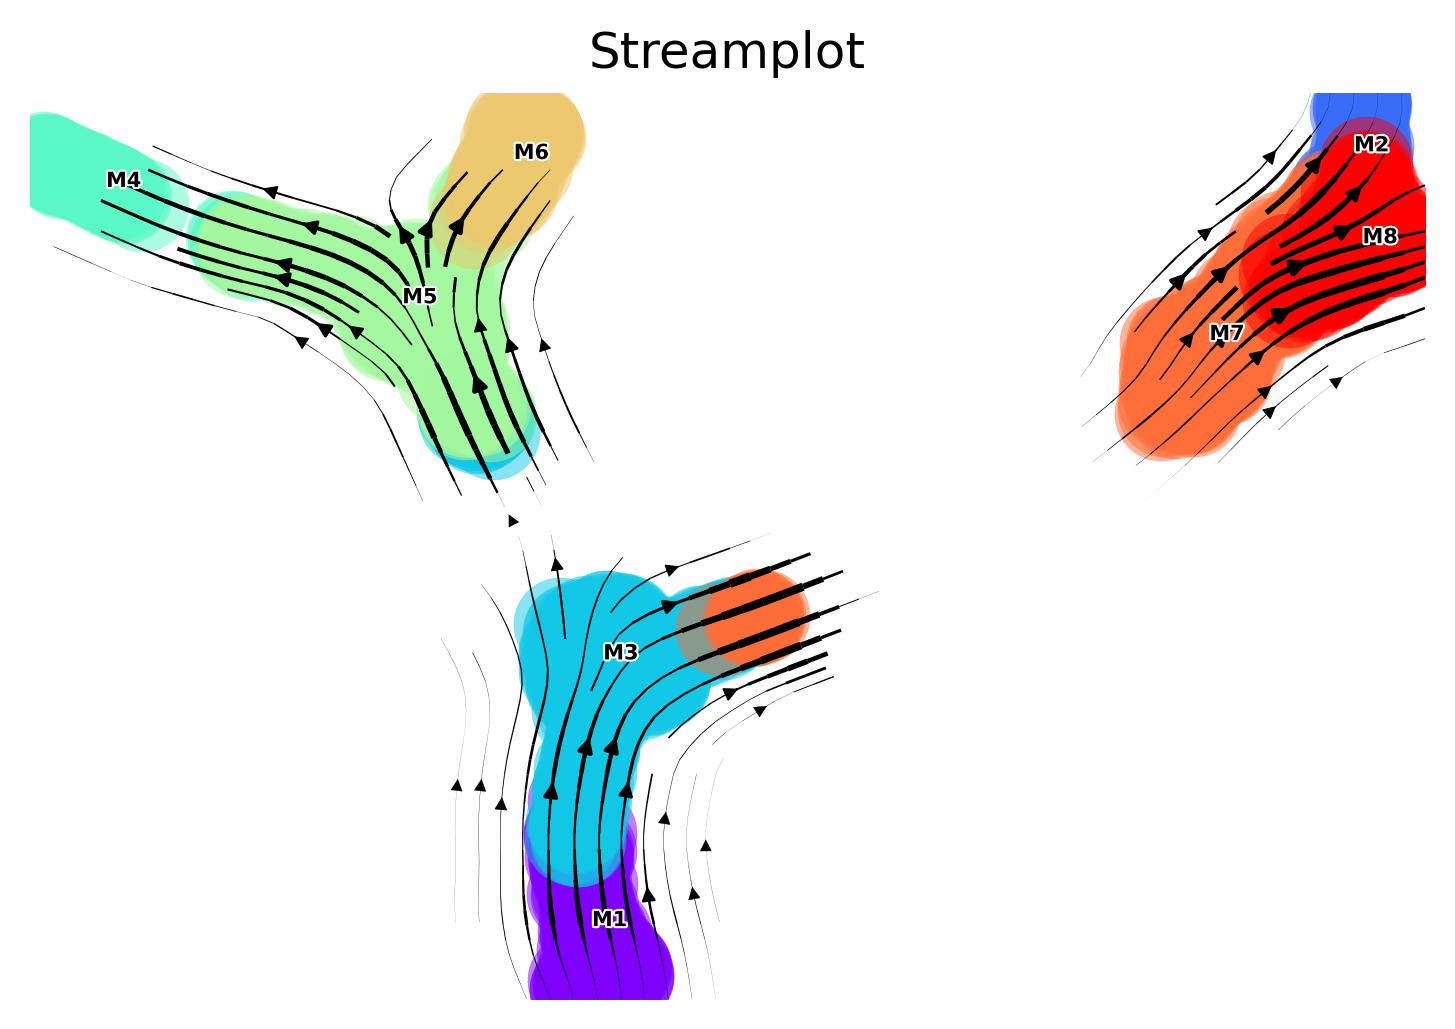

In [9]:
#default parameters:
# scatter_size=500
# scatter_alpha=0.5
# marker_edgewidth=0.1, outline of scatter points
# density_stream = 2, spacing between field lines
# smooth_transition=1,smoothing of transition matrix over neighbors of neighbors
# color_scheme = 'annotation', corresponds to true_labels  (cell types) provided. Can also be set to 'cluster' and 'time' and 'other'
# add_outline_clusters=False
# other_labels = [] provide a list of values for each cell corresponding to the value / annotation you wish to plot

via_streamplot(v0, embedding)

2022-08-24 20:32:55.315504	Inside animated. File will be saved to location /home/shobi/Trajectory/Datasets/Toy3/test_toy3.gif
total number of stream lines 2329


  0%|          | 0/27 [00:00<?, ?it/s]


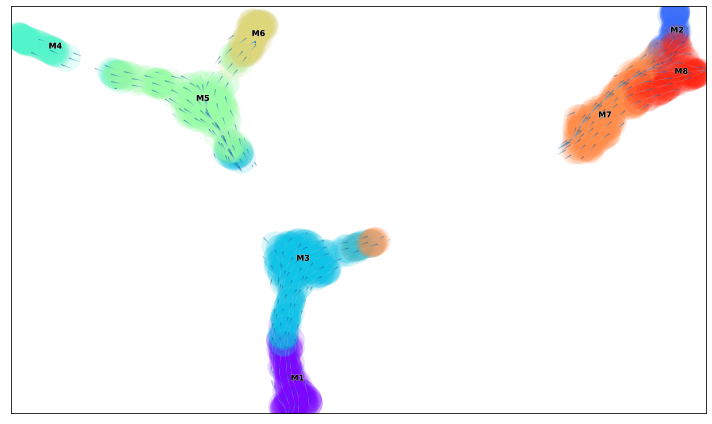

In [10]:
animated_streamplot(v0, embedding, scatter_size=800, scatter_alpha=0.15, density_grid=2,  saveto='/home/shobi/Trajectory/Datasets/Toy3/test_toy3.gif' )

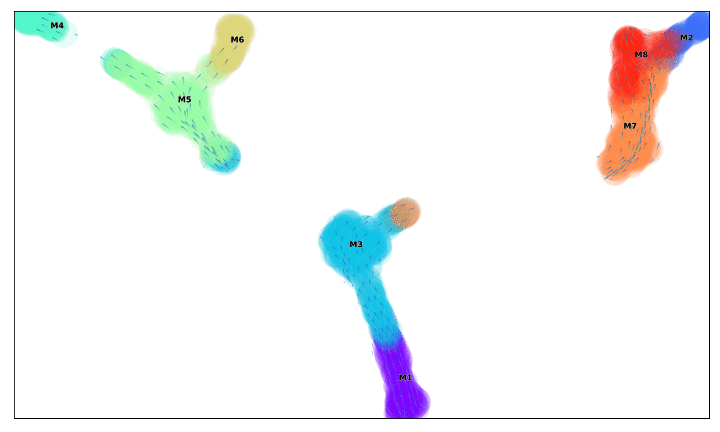

In [15]:
from IPython.display import Image
with open('/home/shobi/Trajectory/Datasets/Toy3/test_toy3.gif','rb') as file:
    display(Image(file.read()))

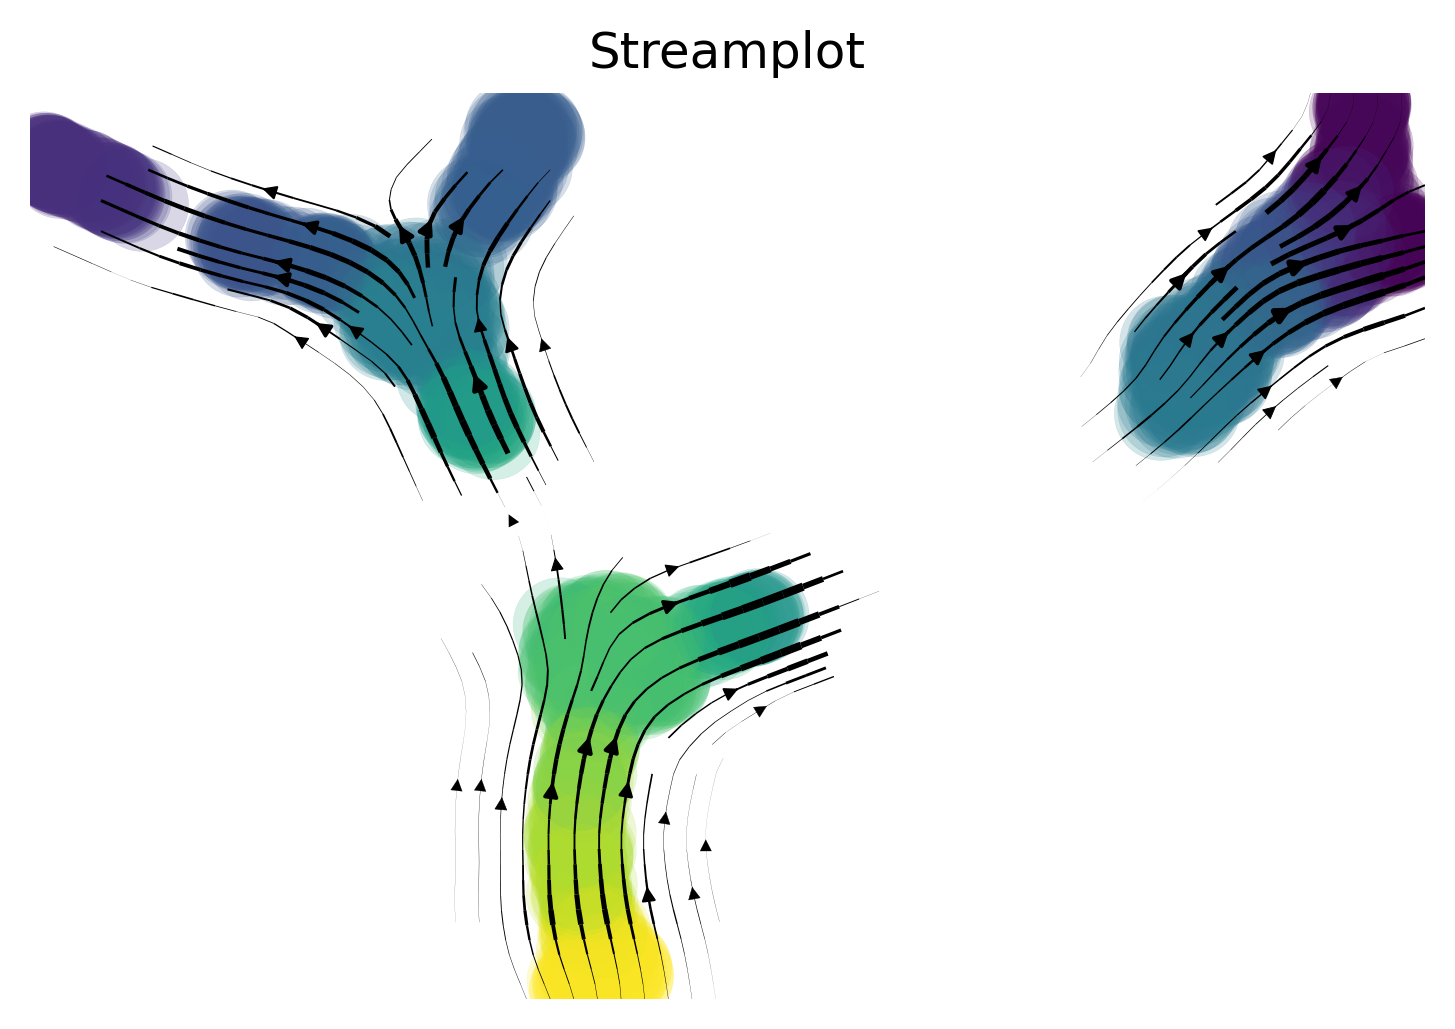

In [11]:
via_streamplot(v0, embedding, color_scheme='time',linewidth=1,min_mass = 1, cutoff_perc = 5,scatter_size=500, scatter_alpha=0.2,marker_edgewidth=0.1, density_stream = 2, smooth_transition=1, smooth_grid=.5)# other args: add_outline_clusters=True, cluster_outline_edgewidth =0.005

### Overall trajectory 
Draw overall pseudotime and main trajectories on single cell embedding 

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |#######################

2022-08-26 13:29:19.041954	Super cluster 4 is a super terminal with sub_terminal cluster 4
2022-08-26 13:29:19.042299	Super cluster 7 is a super terminal with sub_terminal cluster 7
2022-08-26 13:29:19.042495	Super cluster 8 is a super terminal with sub_terminal cluster 8
2022-08-26 13:29:19.042690	Super cluster 9 is a super terminal with sub_terminal cluster 9
2022-08-26 13:29:19.042879	Super cluster 10 is a super terminal with sub_terminal cluster 10


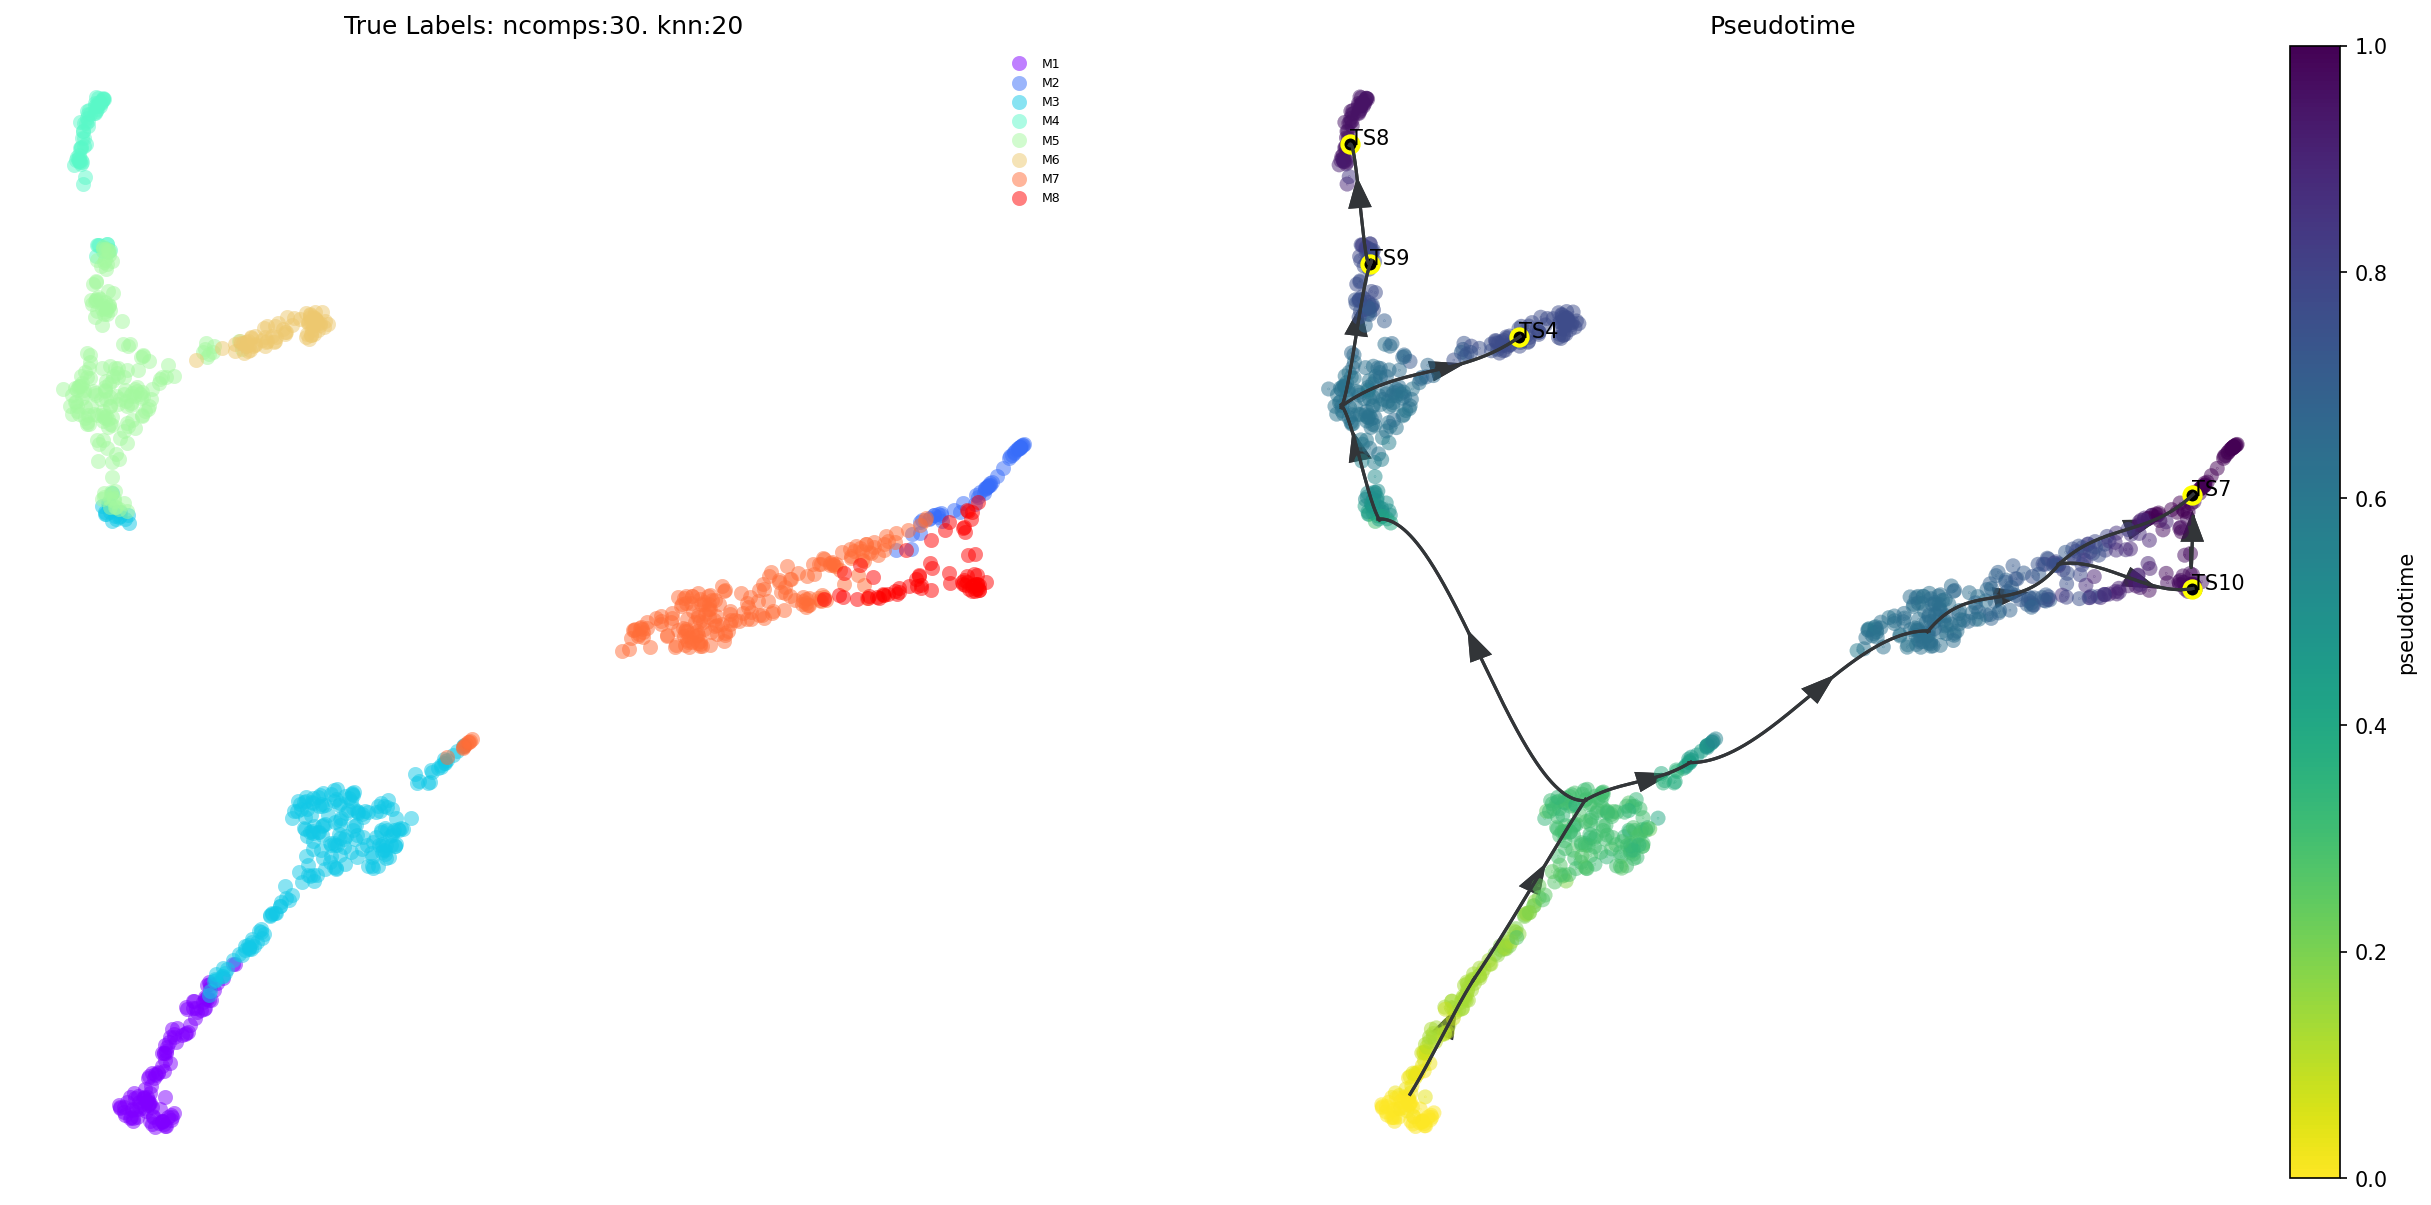

In [11]:
# draw overall pseudotime and main trajectories
draw_trajectory_gams(via_coarse=v0, via_fine=v0, embedding=embedding)
plt.show()

### Lineage probabilities
Plot the lineage probabilities for each lineage (associated with a terminal state)

2022-08-26 13:30:32.096224	Cluster path on clustergraph starting from Root Cluster 6to Terminal Cluster 4
2022-08-26 13:30:32.096312	Cluster path on clustergraph starting from Root Cluster 6to Terminal Cluster 7
2022-08-26 13:30:32.096332	Cluster path on clustergraph starting from Root Cluster 6to Terminal Cluster 8
2022-08-26 13:30:32.096349	Cluster path on clustergraph starting from Root Cluster 6to Terminal Cluster 9
2022-08-26 13:30:32.096366	Cluster path on clustergraph starting from Root Cluster 6to Terminal Cluster 10
2022-08-26 13:30:32.204337	Cluster level path on sc-knnGraph from Root Cluster 6 to Terminal Cluster 1 along path: [6, 6, 6, 3, 1, 1]
2022-08-26 13:30:32.227004	Cluster level path on sc-knnGraph from Root Cluster 6 to Terminal Cluster 2 along path: [6, 6, 3, 1, 11, 2, 2, 2]
2022-08-26 13:30:32.249732	Cluster level path on sc-knnGraph from Root Cluster 6 to Terminal Cluster 3 along path: [6, 6, 3, 3, 3, 3, 3, 3]
2022-08-26 13:30:32.273533	Cluster level path on sc-kn

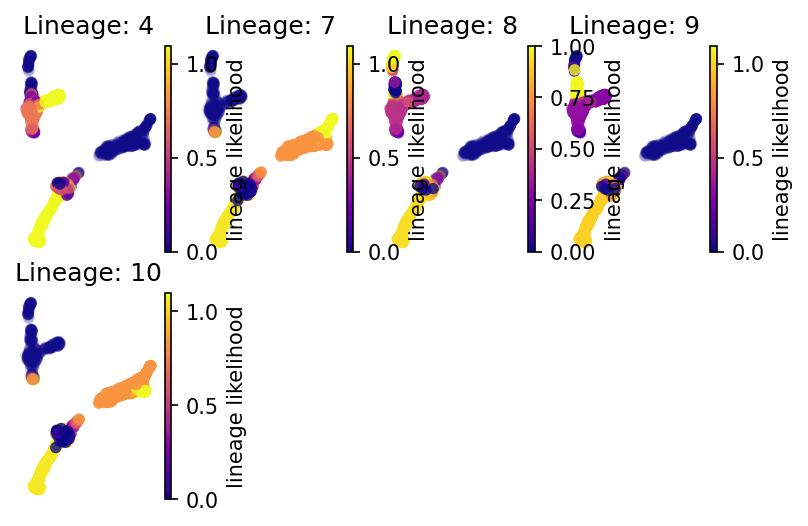

In [12]:
draw_sc_lineage_probability(via_coarse=v0, via_fine=v0,embedding=embedding)
plt.show()

###  Gene Dynamics
Plot the gene expression levels along each lineage for marker genes. Here we use dummy values for the Genes which are just the values of the initial PCs for illustrative purposes

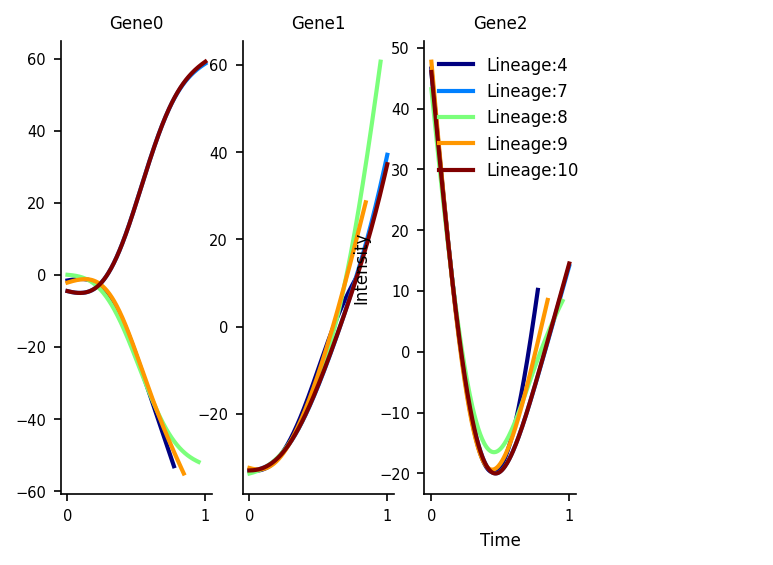

In [13]:
df_subset = pd.DataFrame(adata_counts.obsm['X_pca'][:, 0:3], columns=['Gene0', 'Gene1', 'Gene2'])
get_gene_expression(via0=v0, gene_exp=df_subset, cmap='jet',linewidth=2, fontsize_=8, spline_order=4, n_splines=10) #default parameters shown here for retrieving gene expression


### Optional Second iteration
Sometimes it is desirable to construct a more finegrained clustergraph that uses the terminal states detected in a coarser iteration. 

The rest of the vignette covers how to link the fine and coarse grained iterations of Via. However, it is also possible to simply run a single iteration of Via and do so at various levels of granularity 

Fri Aug 26 13:37:03 2022 Correlation between VIA pseudotime and "temporal annotations 94.0 %
2022-08-26 13:37:03.422875	Running VIA over input data of 1000 (samples) x 30 (features)
2022-08-26 13:37:03.422949	Knngraph has 20 neighbors
2022-08-26 13:37:03.666504	Finished global pruning of 20-knn graph used for clustering. Kept 46.7 % of edges. 
2022-08-26 13:37:03.666792	Commencing community detection
2022-08-26 13:37:03.699822	Finished running Leiden algorithm. Found 43 clusters.
2022-08-26 13:37:03.700184	Found 3 clusters that are too big
2022-08-26 13:37:03.700373	Examining clusters that are above the too_big threshold
2022-08-26 13:37:03.700411	Cluster 2 contains 117>100 samples and is too big
2022-08-26 13:37:03.715935	Examining clusters that are above the too_big threshold
2022-08-26 13:37:03.716196	Cluster 0 contains 125>100 samples and is too big
2022-08-26 13:37:03.732895	Examining clusters that are above the too_big threshold
2022-08-26 13:37:03.733172	Cluster 1 contains 124>1

/home/shobi/anaconda3/envs/ViaEnv/lib/python3.7/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


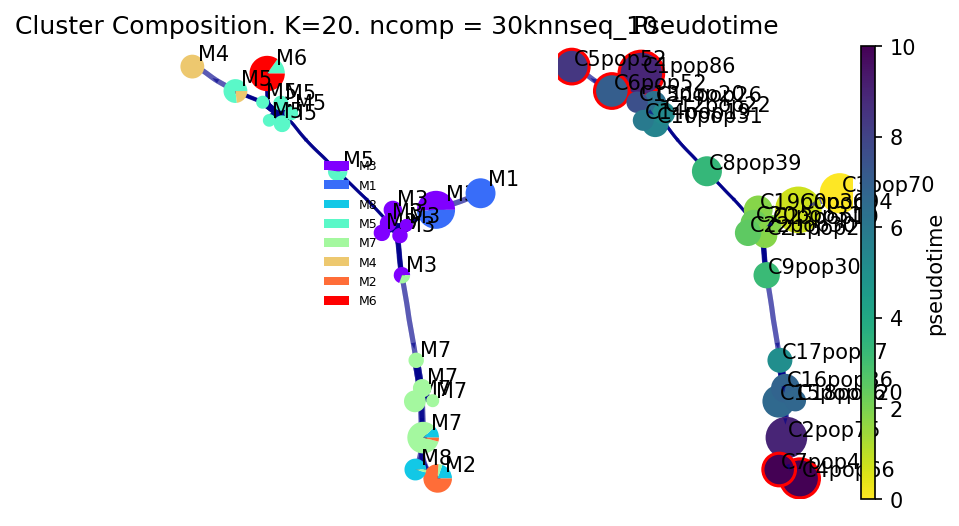

2022-08-26 13:37:08.793156	Time elapsed 5.2 seconds
Fri Aug 26 13:37:08 2022 Correlation between VIA pseudotime and "temporal annotations 90.0 %


In [19]:
adata_counts.obs['pseudotime'] = [i for i in v0.single_cell_pt_markov]
correlation = adata_counts.obs['pseudotime'].corr(adata_counts.obs['true_time'])
print(time.ctime(),'Correlation between VIA pseudotime and "temporal annotations', round(correlation,2)*100,'%')

#the only additional step to link the two iterations is to pass on the v0 iteration to v1 by setting via_coarse = v0 when initializing VIA and setting is_coarse = False

v1 = VIA(adata_counts.obsm['X_pca'][:, 0:ncomps], true_label, jac_std_global=0.15, dist_std_local=1,
             knn=knn,too_big_factor=0.1,   cluster_graph_pruning_std=1, root_user=root_user, is_coarse=False,
             x_lazy=0.95, alpha_teleport=0.99, preserve_disconnected=True, dataset='group',random_seed=random_seed, via_coarse=v0)  

v1.run_VIA()
labels = v1.labels
adata_counts.obs['pseudotime_v1'] = [i for i in v1.single_cell_pt_markov] 
correlation = adata_counts.obs['pseudotime_v1'].corr(adata_counts.obs['true_time'])
print(time.ctime(),'Correlation between VIA pseudotime and true temporal annotations', round(correlation,2)*100,'%')

2022-08-26 13:37:31.344882	Cluster path on clustergraph starting from Root Cluster 3to Terminal Cluster 1
2022-08-26 13:37:31.345180	Cluster path on clustergraph starting from Root Cluster 3to Terminal Cluster 4
2022-08-26 13:37:31.345219	Cluster path on clustergraph starting from Root Cluster 3to Terminal Cluster 5
2022-08-26 13:37:31.345241	Cluster path on clustergraph starting from Root Cluster 3to Terminal Cluster 6
2022-08-26 13:37:31.345263	Cluster path on clustergraph starting from Root Cluster 3to Terminal Cluster 7
2022-08-26 13:37:31.451416	Cluster level path on sc-knnGraph from Root Cluster 3 to Terminal Cluster 1 along path: [3, 3, 0, 8, 1, 1, 1, 1]
2022-08-26 13:37:31.474942	Cluster level path on sc-knnGraph from Root Cluster 3 to Terminal Cluster 2 along path: [3, 3, 0, 9, 2, 2]
2022-08-26 13:37:31.499701	Cluster level path on sc-knnGraph from Root Cluster 3 to Terminal Cluster 3 along path: [3]
2022-08-26 13:37:31.526970	Cluster level path on sc-knnGraph from Root Cluste

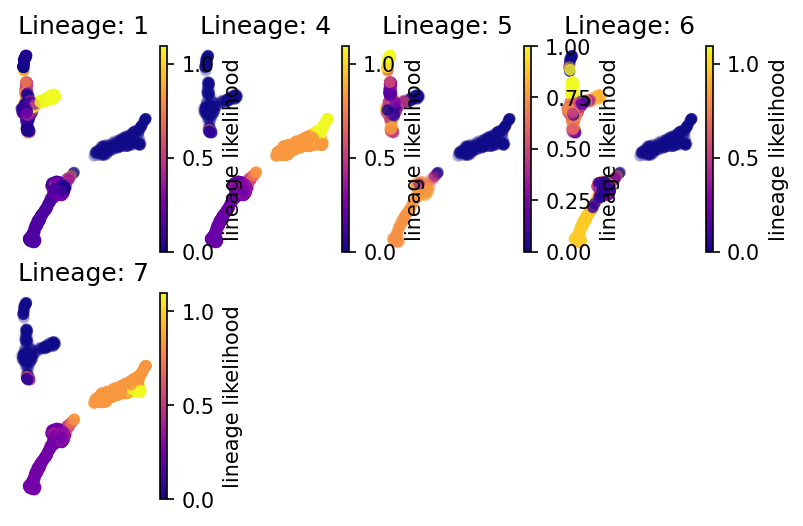

In [20]:
draw_sc_lineage_probability(v0,v1,embedding)
plt.show()

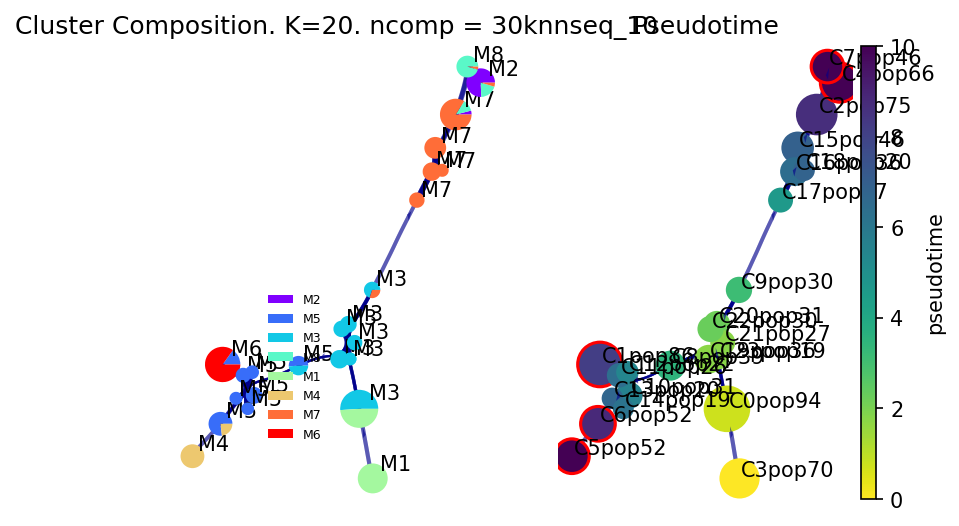

In [11]:
draw_piechart_graph(via0=v1, type_data='pt', title='Toy multifurcation', cmap='viridis_r', ax_text=True, gene_exp='')

/home/shobi/anaconda3/envs/ViaEnv/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


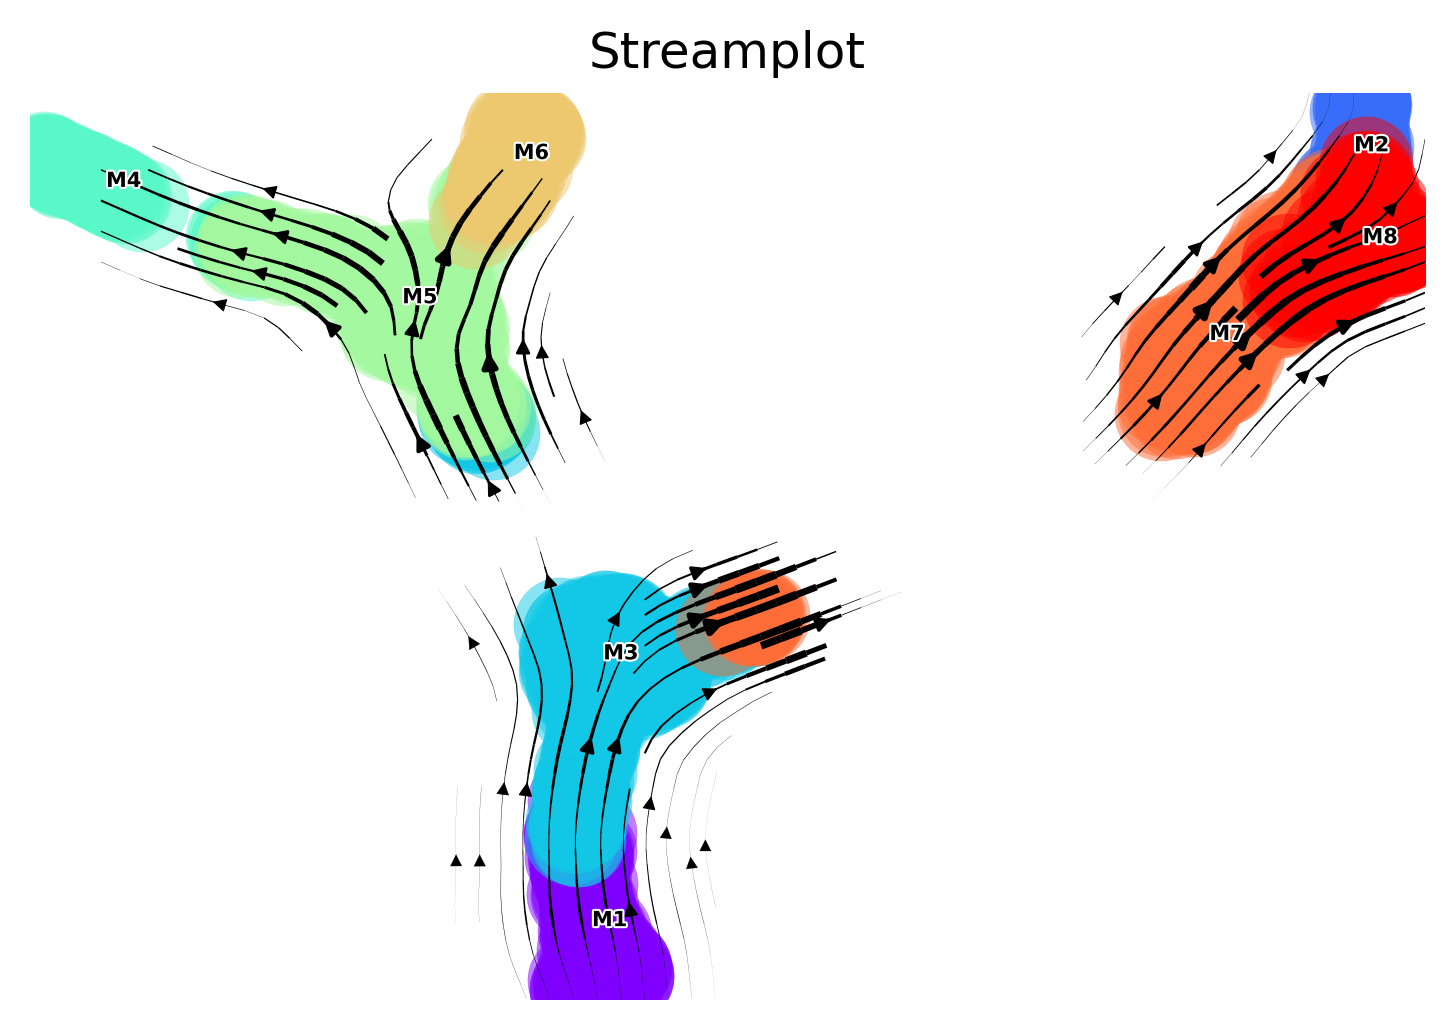

In [17]:
via_streamplot(v1, embedding)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |#######################

2022-08-24 20:35:32.361901	Super cluster 4 is a super terminal with sub_terminal cluster 1
2022-08-24 20:35:32.362226	Super cluster 7 is a super terminal with sub_terminal cluster 4
2022-08-24 20:35:32.362411	Super cluster 8 is a super terminal with sub_terminal cluster 7
2022-08-24 20:35:32.362577	Super cluster 9 is a super terminal with sub_terminal cluster 6
2022-08-24 20:35:32.362749	Super cluster 10 is a super terminal with sub_terminal cluster 8


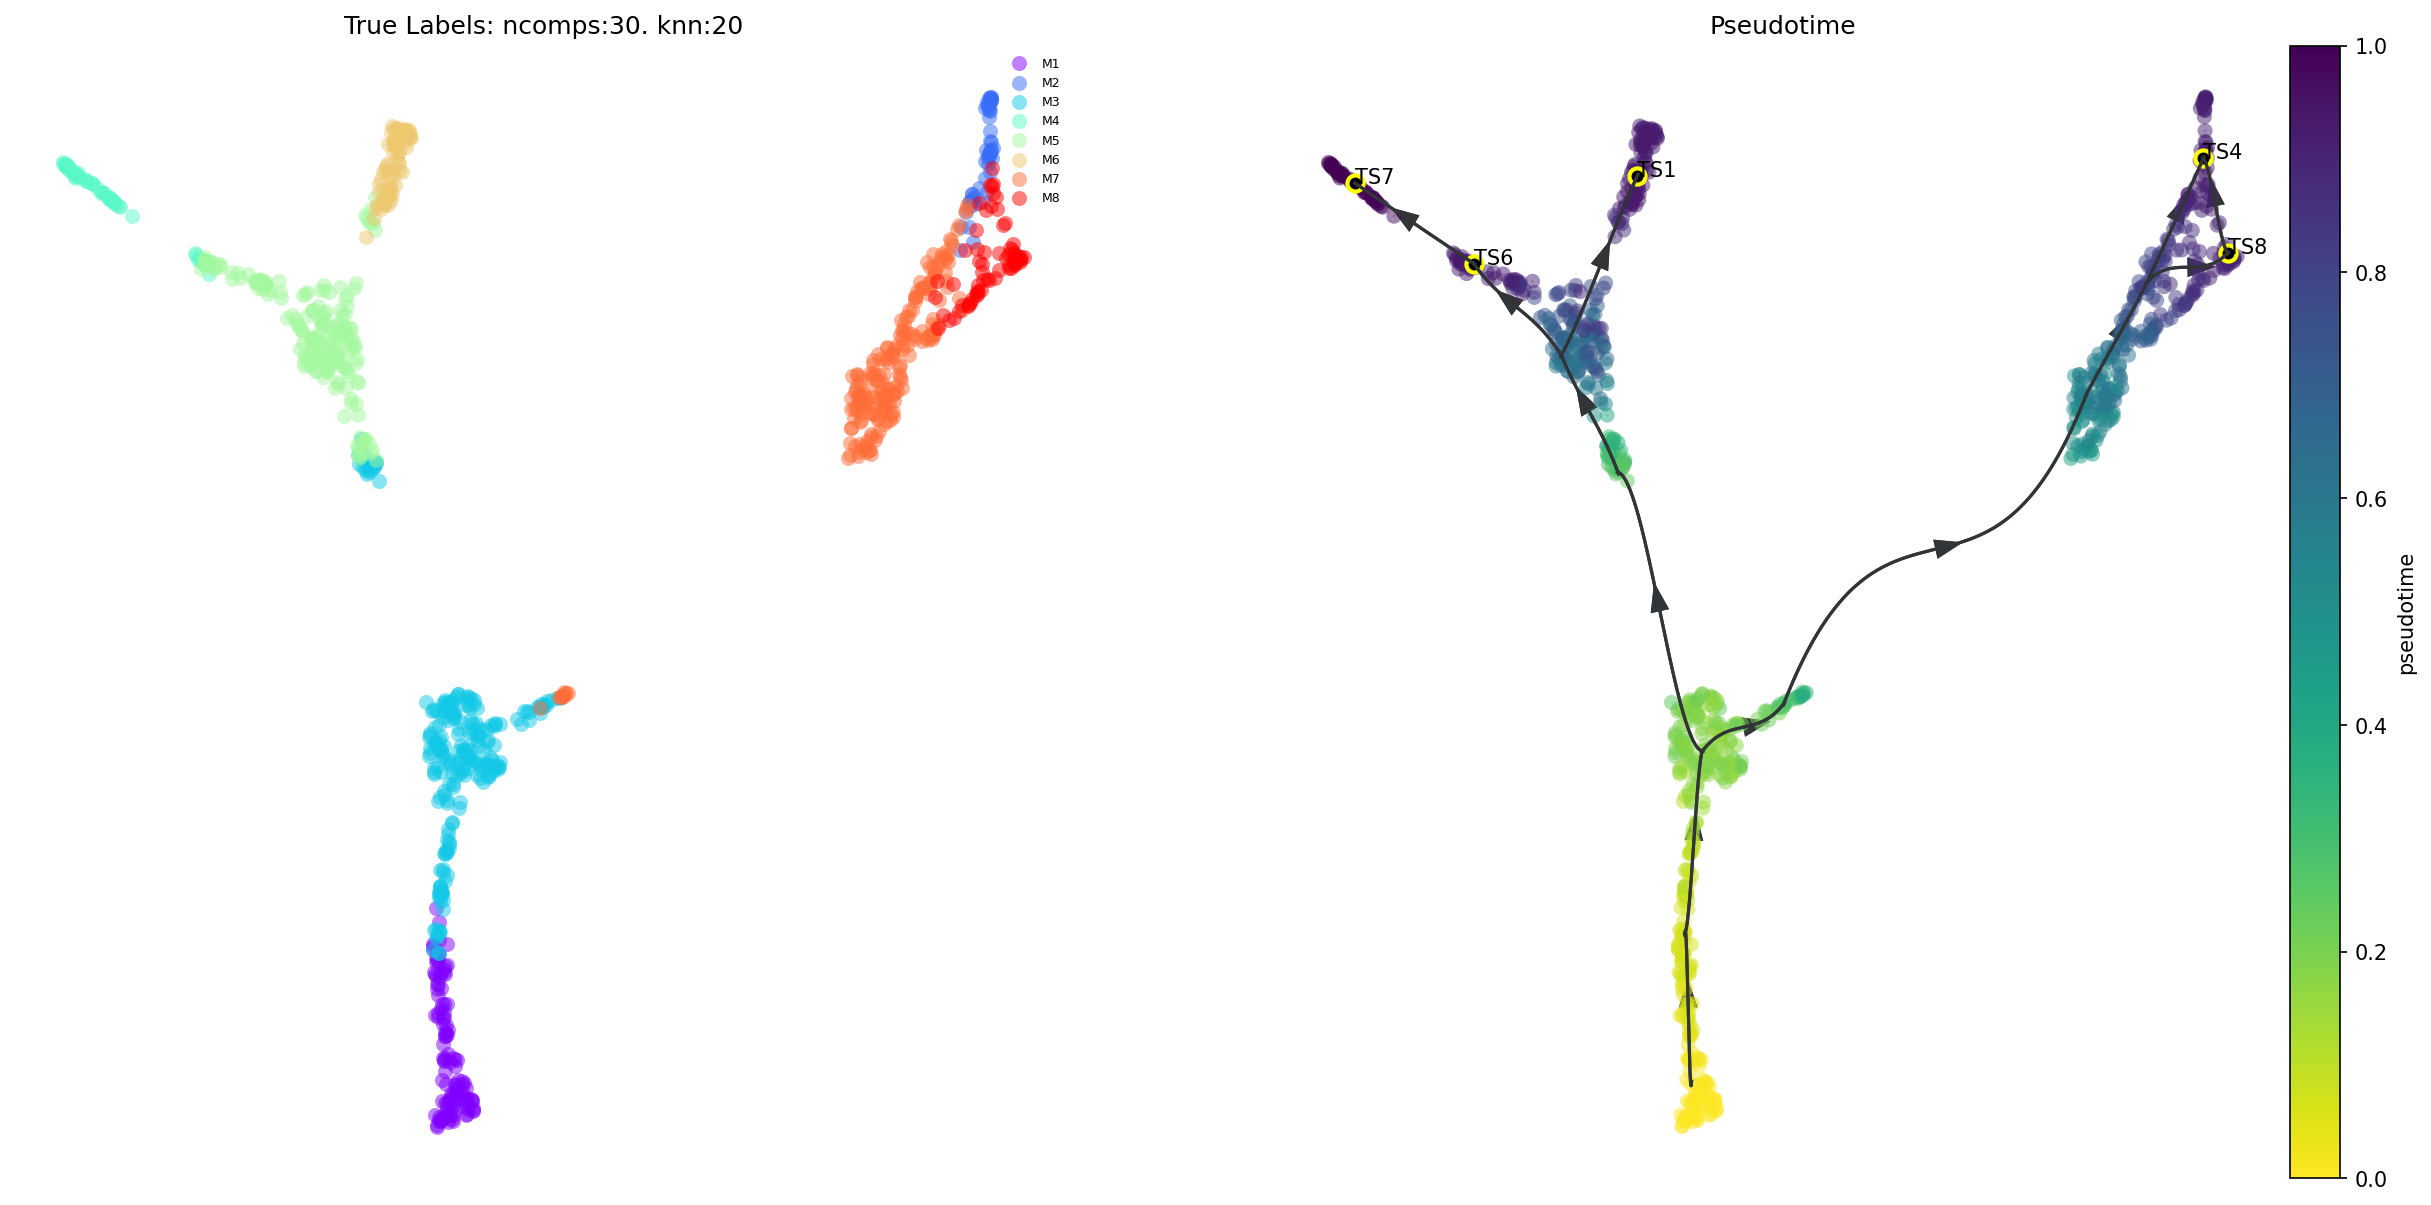

In [18]:
draw_trajectory_gams(via_coarse=v0, via_fine=v1, embedding=embedding)